# universal estimator (exp-3)

In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=4)

In [2]:
from scipy import stats
from scipy.stats import lognorm

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

def next_config(search_space):
    """
    return a (uniform) random parameter within search_space
    """
    low = search_space[0]
    high = search_space[1]
    return np.random.uniform(low, high, size=1)[0]

In [3]:
def MAE(e, axis=-1):
    """mean absolute error"""
    return np.mean(np.abs(e), axis=axis)

NUM_BINS = 346

def estimator_exp_3(f, sample, d_true, search_space=np.array([0.0, 1.0]), num_trials=10):
    """
    Learn parameters of f, from sample.
    Arguments:
        - f: one dimensional function that gives the PMF of a univariate distribution.
        - sample: generated using f.
    """

    # experiment results
    res = {
        'search_space': [],
        'pred_params': [],
        'test_params': [],
        'pred_params_MAE': [],
        'd_true': d_true,
        'd_pred': [],
    }

    # number of observations in sample
    M = len(sample)
    N = 1000
    nbins = NUM_BINS
#     search_space = np.array([0.0, 1.0])
#     search_space = np.array([0.8879, 0.9952])
#     search_space = np.array([0.9022, 0.9679])
#     search_space = np.array([0.9192, 0.9574])

    # Generate a histogram for the input *sample*
    H_sample = np.histogram(sample, bins=nbins, range=(0,nbins), density=False)[0]
    H_sample = np.reshape(H_sample, (1, -1))
    print(f'*** input histogram max value: {np.max(H_sample)}, nbins={nbins}')
    
    # Iterate   
    d_pred_array = np.zeros(num_trials)
    for trial_idx in range(num_trials):

        # 1. Generate synthetic data-sets (train/test) using f (within search_space)
        # -----------------------------------------------------------------------------------------------
        print()
        print(f'trial ({trial_idx+1}/{num_trials}) - search_space: {search_space}')
        print(f'generating data (M={M}, N={N}) ...', end=' ')

        raw, H, params = generate_data(N=N, 
                                       M=M, 
                                       sample=f, 
                                       nextConfig=lambda: next_config(search_space),
                                       nbins=nbins,
                                       density=False, 
                                       apply_log_scale=False)

        H_train, H_test, train_params, test_params = train_test_split(H, 
                                                                      params, 
                                                                      test_size=0.25, 
                                                                      random_state=RANDOM_STATE)
        print(f'train histogram shape: {H_train.shape}', end=' ')

        # 2. Fit a DNN model to train-set and predict on test-set
        # -----------------------------------------------------------------------------------------------

        # train
        print(f'training dnn model ...')
        start_time = time.time()
        dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)
        train_time = time.time() - start_time

        # predict
        pred_params = dnn_model.predict(H_test).flatten()

        # calc mean/max absolute error
        e = pred_params - test_params
        pred_params_MAE = MAE(e)
        print(f'*** test_MEAN_abs_error: {pred_params_MAE:.4f}')
        test_MAX_abs_error = np.max( np.abs(e) )
        print(f'*** test_MAX_abs_error: {test_MAX_abs_error:.4f}')
        test_3_STD = 3 * np.std(e)
        print(f'*** test_3_STD: {test_3_STD:.4f}')

        # 3. Predict the parameter (d_pred) on the input sample
        # -----------------------------------------------------------------------------------------------

        d_pred = dnn_model.predict(H_sample).flatten()[0]
        print(f'*** d_pred: {d_pred:.4f}', end=' ')
        print(f'*** abs(d_pred - d_true): {abs(d_pred - d_true):.4f}')
        d_pred_array[trial_idx] = d_pred

    return d_pred_array

### Fit (lognormal)


param true value: 0.92
Iteration: 1
*** input histogram max value: 134, nbins=346

trial (1/10) - search_space: [0.0, 1.0]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0553
*** test_MAX_abs_error: 0.1934
*** test_3_STD: 0.2099
*** d_pred: 0.7062 *** abs(d_pred - d_true): 0.2138

trial (2/10) - search_space: [0.0, 1.0]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0531
*** test_MAX_abs_error: 0.2767
*** test_3_STD: 0.1971
*** d_pred: 0.8321 *** abs(d_pred - d_true): 0.0879

trial (3/10) - search_space: [0.0, 1.0]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0578
*** test_MAX_abs_error: 0.2426
*** test_3_STD: 0.2191
*** d_pred: 0.9081 *** abs(d_pred - d_true): 0.0119

trial (4/10) - search_space: [0.0, 1.0]
generating data (M=256, N=1000) ... train histogram shape: (

*** test_MEAN_abs_error: 0.0370
*** test_MAX_abs_error: 0.1470
*** test_3_STD: 0.1397
*** d_pred: 0.9121 *** abs(d_pred - d_true): 0.0079
mean: 0.922516
std: 0.026421
search_space: [0.8697 0.9754]
Iteration: 1
*** input histogram max value: 134, nbins=346

trial (1/10) - search_space: [0.8697 0.9754]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0297
*** test_MAX_abs_error: 0.1074
*** test_3_STD: 0.1065
*** d_pred: 0.9046 *** abs(d_pred - d_true): 0.0154

trial (2/10) - search_space: [0.8697 0.9754]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0267
*** test_MAX_abs_error: 0.1007
*** test_3_STD: 0.0966
*** d_pred: 0.9570 *** abs(d_pred - d_true): 0.0370

trial (3/10) - search_space: [0.8697 0.9754]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0289
*** test_MAX_abs_er

*** test_MEAN_abs_error: 0.0190
*** test_MAX_abs_error: 0.0651
*** test_3_STD: 0.0692
*** d_pred: 0.9326 *** abs(d_pred - d_true): 0.0126

trial (10/10) - search_space: [0.89   0.9522]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0165
*** test_MAX_abs_error: 0.0507
*** test_3_STD: 0.0592
*** d_pred: 0.9169 *** abs(d_pred - d_true): 0.0031
mean: 0.920499
std: 0.009829
search_space: [0.9008 0.9402]
Iteration: 1
*** input histogram max value: 134, nbins=346

trial (1/10) - search_space: [0.9008 0.9402]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0111
*** test_MAX_abs_error: 0.0533
*** test_3_STD: 0.0411
*** d_pred: 0.9115 *** abs(d_pred - d_true): 0.0085

trial (2/10) - search_space: [0.9008 0.9402]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0119
*** test_MAX_abs_e

*** test_MEAN_abs_error: 0.0069
*** test_MAX_abs_error: 0.0279
*** test_3_STD: 0.0238
*** d_pred: 0.9265 *** abs(d_pred - d_true): 0.0065

trial (9/10) - search_space: [0.9164 0.9365]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0064
*** test_MAX_abs_error: 0.0231
*** test_3_STD: 0.0233
*** d_pred: 0.9277 *** abs(d_pred - d_true): 0.0077

trial (10/10) - search_space: [0.9164 0.9365]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0066
*** test_MAX_abs_error: 0.0319
*** test_3_STD: 0.0232
*** d_pred: 0.9259 *** abs(d_pred - d_true): 0.0059
mean: 0.928229
std: 0.004528
search_space: [0.9192 0.9373]
Iteration: 1
*** input histogram max value: 134, nbins=346

trial (1/10) - search_space: [0.9192 0.9373]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0064
*** test_MAX_abs_e

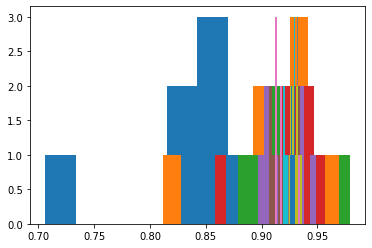

In [4]:
d_true = 0.92
# d_true = 0.85
print()
print(f'param true value: {d_true}')
sample = sample_lognormal(config=d_true, size=256)

it = 0
search_space = [0.0, 10.0]
while True:
    it += 1
    print(f'Iteration: {it+1}')
    d_pred_array = estimator_exp_3(
        f=sample_lognormal, 
        sample=sample, 
        d_true=d_true, 
        search_space=search_space, 
        num_trials=10)
    
    mean= np.mean(d_pred_array)
    print(f'mean: {mean:.6f}')
    
    std = np.std(d_pred_array)
    print(f'std: {std:.6f}')
    
    # narrow search_space
    search_space = np.array([mean-2*std, mean+2*std])
    print(f'search_space: {search_space}')
    
    nbins = len(d_pred_array)
    _ = plt.hist(d_pred_array, bins=nbins)

    search_space_width = search_space[1] - search_space[0]
    if search_space_width < 0.01:
        break


trial (10/10) - search_space: [0.9158 0.9387]  
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...  
*** test_MEAN_abs_error: 0.0063  
*** test_MAX_abs_error: 0.0229  
*** test_3_STD: 0.0239  
*** d_pred: 0.9279 *** abs(d_pred - d_true): 0.0079  
mean: 0.926339  
std: 0.002082  
search_space: [0.9222 0.9305]  
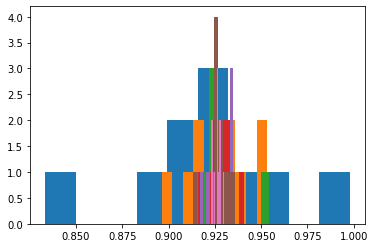

trial (10/10) - search_space: [0.9168 0.933 ]  
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...  
*** test_MEAN_abs_error: 0.0052  
*** test_MAX_abs_error: 0.0151  
*** test_3_STD: 0.0183  
*** d_pred: 0.9267 *** abs(d_pred - d_true): 0.0067  
mean: 0.926953  
std: 0.001952  
search_space: [0.923  0.9309]  
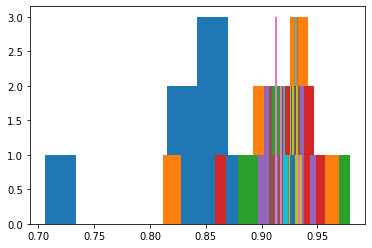